In [1]:
import MetaTrader5 as mt5
import datetime
import talib as ta
import pandas as pd
import numpy as np
import os
import csv
import win32com.client
import mplfinance as mpf


# connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()


print('Connected Version: ' + str(mt5.version()))
speaker = win32com.client.Dispatch("SAPI.SpVoice")
speaker.Speak('connected to Meta trader')

Connected Version: (500, 4153, '22 Jan 2024')


1

In [8]:


def get_symbol_data(symbol, closed_candles_only=True, periods=300, timeframe=mt5.TIMEFRAME_M5):
    print("get symbol history")

    
    data = pd.DataFrame(mt5.copy_rates_from_pos(
        symbol,
        timeframe,
        0,
        periods
    ))
    
    # create a field converting to local date and time
    seven_hours = datetime.timedelta(hours=7)
    data = (data
        .assign(server_time = pd.to_datetime(data.time, unit="s").astype(str))
        .assign(time = pd.to_datetime( data.time, unit="s") - seven_hours)
        .assign(local_time = pd.to_datetime( data.time, unit="s") - seven_hours)
        .set_index("time")
        .sort_index(ascending=True)

       )
    
    # basic candle statistics
    data = (data
        .assign(cdl_size = abs(data.high - data.low))
        .assign(cdl_body_size = abs(data.close - data.open))
        .assign(cdl_up = np.where(data.open < data.close, True, False))
        .assign(cdl_down = np.where(data.open > data.close, True, False))
       )

    data = (data 
        .assign(cdl_body_perc = data.cdl_body_size / data.cdl_size )
       )

    #data.rename(columns={"open": "Open", "close": "Close", "low": "Low", "high": "High", "volume": "Volume"}, inplace=True)

    # Add technical indicators
    data  = (data
             .assign(ind_rsi = ta.RSI(data.close, 14),
                    ind_adx = ta.ADX(data.high, data.low, data.close, timeperiod=14),
                    ind_atr = ta.ATR(data.high, data.low, data.close, timeperiod=14),
                    ind_sma9 = data.close.rolling(9).mean(),
                    ind_sma15 = data.close.rolling(15).mean(),
                    ind_sma21 = data.close.rolling(21).mean(),
                   
                )
           
            .assign(
                ptn_bullish_engulfing = np.where(ta.CDLENGULFING(data.open, data.high, data.low, data.close) == 100, True, False),
                ptn_bearish_engulfing = np.where(ta.CDLENGULFING(data.open, data.high, data.low, data.close) == -100, True, False),
                ptn_morningstar = np.where(ta.CDLMORNINGSTAR(data.open, data.high, data.low, data.close, penetration=0) == 100, True, False),
                ptn_eveningstar = np.where(ta.CDLEVENINGSTAR(data.open, data.high, data.low, data.close, penetration=0) == 100, True, False),

                )
            )
    
    data = data.assign( ind_ma_bullish = np.where(data.ind_sma9 > data.ind_sma21, 1.0, 0.0))

    data = data.assign( ind_ma_cross = data.ind_ma_bullish.diff())
            
    # most recent bar is incomplete, we need to remove it
    # we only want to use completed candles
    if closed_candles_only:
        data.drop(data.tail(1).index, inplace=True)
       

    # make sure first row is the most current time
    data.sort_index(ascending=False, inplace=True)
    
    #print(data.loc[:, data.columns.str.startswith( ('ind_', 'ptn_') )].query("ptn_bullish_engulfing or ptn_bearish_engulfing"))
   

    previous_cdl = data.shift(-1)
    data["ptn_bullish_engulfing_1"] = np.where(
            (data.open <= previous_cdl.close) &
            (data.close >= previous_cdl.open) &
            (data.cdl_up & previous_cdl.cdl_down),
            True, False
        )

    data["ptn_bearish_engulfing_1"] = np.where(
            (data.open >= previous_cdl.close) &
            (data.close <= previous_cdl.open) &
            (data.cdl_down & previous_cdl.cdl_up), 
            True, False
        )
    

    # is rsi overbougth or oversold

    data["is_prev_trend_down"] = np.where(
        ( data.shift(-1).cdl_down == True ) &
        ( data.shift(-2).cdl_down == True ) &
        ( data.shift(-3).cdl_down == True ),
        True, False
    )

    data["is_prev_trend_up"] = np.where(
        ( data.shift(-1).cdl_up == True ) &
        ( data.shift(-2).cdl_up == True ) &
        ( data.shift(-3).cdl_up == True ),
        True, False
    )
    

    

    return data


In [16]:
data = get_symbol_data("ETHUSD", closed_candles_only=True, periods=100, timeframe=mt5.TIMEFRAME_M5)
data

get symbol history


,open,high,low,close,tick_volume,spread,real_volume,server_time,local_time,cdl_size,...,ptn_bullish_engulfing,ptn_bearish_engulfing,ptn_morningstar,ptn_eveningstar,ind_ma_bullish,ind_ma_cross,ptn_bullish_engulfing_1,ptn_bearish_engulfing_1,is_prev_trend_down,is_prev_trend_up
time,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:25:00,2217.68,2217.68,2211.96,2215.19,354,146,0,2024-01-26 00:25:00,2024-01-25 17:25:00,5.72,...,False,False,False,False,0.0,0.0,False,True,False,False
2024-01-25 17:20:00,2216.89,2217.80,2215.66,2217.68,419,146,0,2024-01-26 00:20:00,2024-01-25 17:20:00,2.14,...,False,False,False,False,0.0,0.0,True,False,False,False
2024-01-25 17:15:00,2217.65,2217.65,2214.63,2216.89,530,146,0,2024-01-26 00:15:00,2024-01-25 17:15:00,3.02,...,False,False,False,False,0.0,0.0,False,False,False,False
2024-01-25 17:10:00,2214.77,2217.83,2213.80,2217.65,533,146,0,2024-01-26 00:10:00,2024-01-25 17:10:00,4.03,...,False,False,False,False,0.0,0.0,True,False,False,False
2024-01-25 17:05:00,2215.94,2216.02,2214.09,2214.77,429,146,0,2024-01-26 00:05:00,2024-01-25 17:05:00,1.93,...,False,False,False,False,0.0,-1.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25 09:30:00,2208.39,2214.08,2207.65,2212.58,1112,146,0,2024-01-25 16:30:00,2024-01-25 09:30:00,6.43,...,False,False,False,False,0.0,0.0,True,False,False,False
2024-01-25 09:25:00,2209.88,2210.00,2206.47,2208.39,786,146,0,2024-01-25 16:25:00,2024-01-25 09:25:00,3.53,...,False,False,False,False,0.0,0.0,False,False,False,True
2024-01-25 09:20:00,2208.18,2210.50,2206.12,2210.00,940,146,0,2024-01-25 16:20:00,2024-01-25 09:20:00,4.38,...,False,False,False,False,0.0,0.0,False,False,False,False


In [11]:
data.query("ptn_bullish_engulfing_1	== True and is_prev_trend_down == True")


,open,high,low,close,tick_volume,spread,real_volume,server_time,local_time,cdl_size,...,ptn_bullish_engulfing,ptn_bearish_engulfing,ptn_morningstar,ptn_eveningstar,ind_ma_bullish,ind_ma_cross,ptn_bullish_engulfing_1,ptn_bearish_engulfing_1,is_prev_trend_down,is_prev_trend_up
time,,,,,,,,,,,,,,,,,,,,,
2024-01-25 16:25:00,2222.95,2225.12,2222.95,2224.17,627,146,0,2024-01-25 23:25:00,2024-01-25 16:25:00,2.17,...,True,False,False,False,1.0,0.0,True,False,True,False
2024-01-25 10:55:00,2182.33,2193.22,2181.55,2186.89,1116,146,0,2024-01-25 17:55:00,2024-01-25 10:55:00,11.67,...,False,False,False,False,0.0,0.0,True,False,True,False


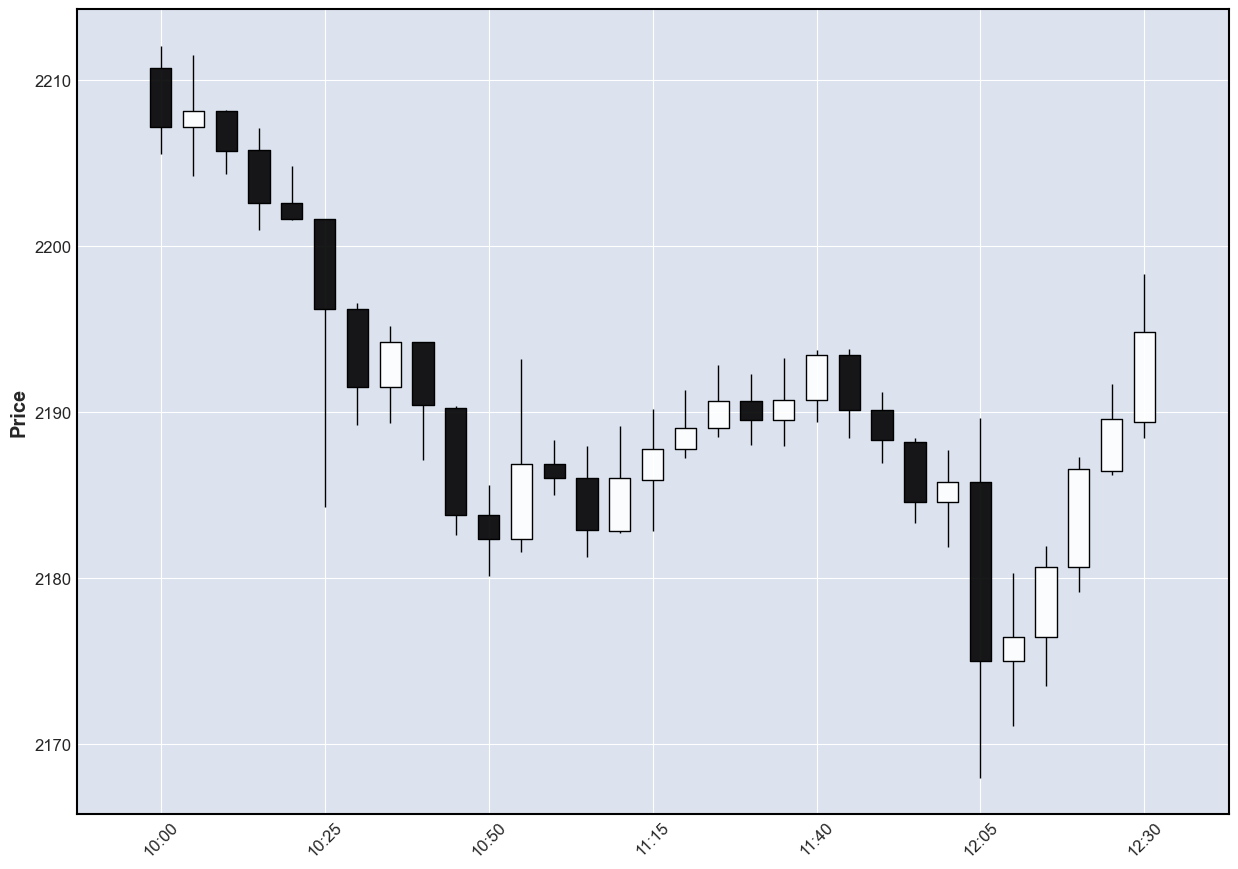

In [13]:
focus_data = data.between_time("10:00", "12:30").sort_index(ascending=True)

mpf.plot(focus_data, type="candle", figscale=2.0)

    


In [28]:
test_data = pd.read_csv("test_data.csv", parse_dates=True, index_col="time")
test_data


,open,high,low,close,tick_volume,spread,real_volume,server_time,local_time,cdl_size,...,ptn_bullish_engulfing,ptn_bearish_engulfing,ptn_morningstar,ptn_eveningstar,ind_ma_bullish,ind_ma_cross,ptn_bullish_engulfing_1,ptn_bearish_engulfing_1,is_prev_trend_down,is_prev_trend_up
time,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:20:00,2216.89,2217.80,2215.66,2217.68,419,146,0,2024-01-26 00:20:00,2024-01-25 17:20:00,2.14,...,False,False,False,False,0.0,0.0,True,False,False,False
2024-01-25 17:15:00,2217.65,2217.65,2214.63,2216.89,530,146,0,2024-01-26 00:15:00,2024-01-25 17:15:00,3.02,...,False,False,False,False,0.0,0.0,False,False,False,False
2024-01-25 17:10:00,2214.77,2217.83,2213.80,2217.65,533,146,0,2024-01-26 00:10:00,2024-01-25 17:10:00,4.03,...,False,False,False,False,0.0,0.0,True,False,False,False
2024-01-25 17:05:00,2215.94,2216.02,2214.09,2214.77,429,146,0,2024-01-26 00:05:00,2024-01-25 17:05:00,1.93,...,False,False,False,False,0.0,-1.0,False,False,False,False
2024-01-25 16:55:00,2217.44,2219.35,2216.21,2218.30,465,146,0,2024-01-25 23:55:00,2024-01-25 16:55:00,3.14,...,False,False,False,False,1.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-24 16:40:00,2209.75,2214.75,2208.39,2213.31,672,146,0,2024-01-24 23:40:00,2024-01-24 16:40:00,6.36,...,False,False,False,False,0.0,0.0,True,False,False,False
2024-01-24 16:35:00,2211.03,2211.35,2208.51,2209.75,640,146,0,2024-01-24 23:35:00,2024-01-24 16:35:00,2.84,...,False,False,False,False,0.0,0.0,False,False,False,False
2024-01-24 16:30:00,2212.90,2213.47,2210.16,2211.03,560,146,0,2024-01-24 23:30:00,2024-01-24 16:30:00,3.31,...,False,False,False,False,0.0,0.0,False,False,False,False


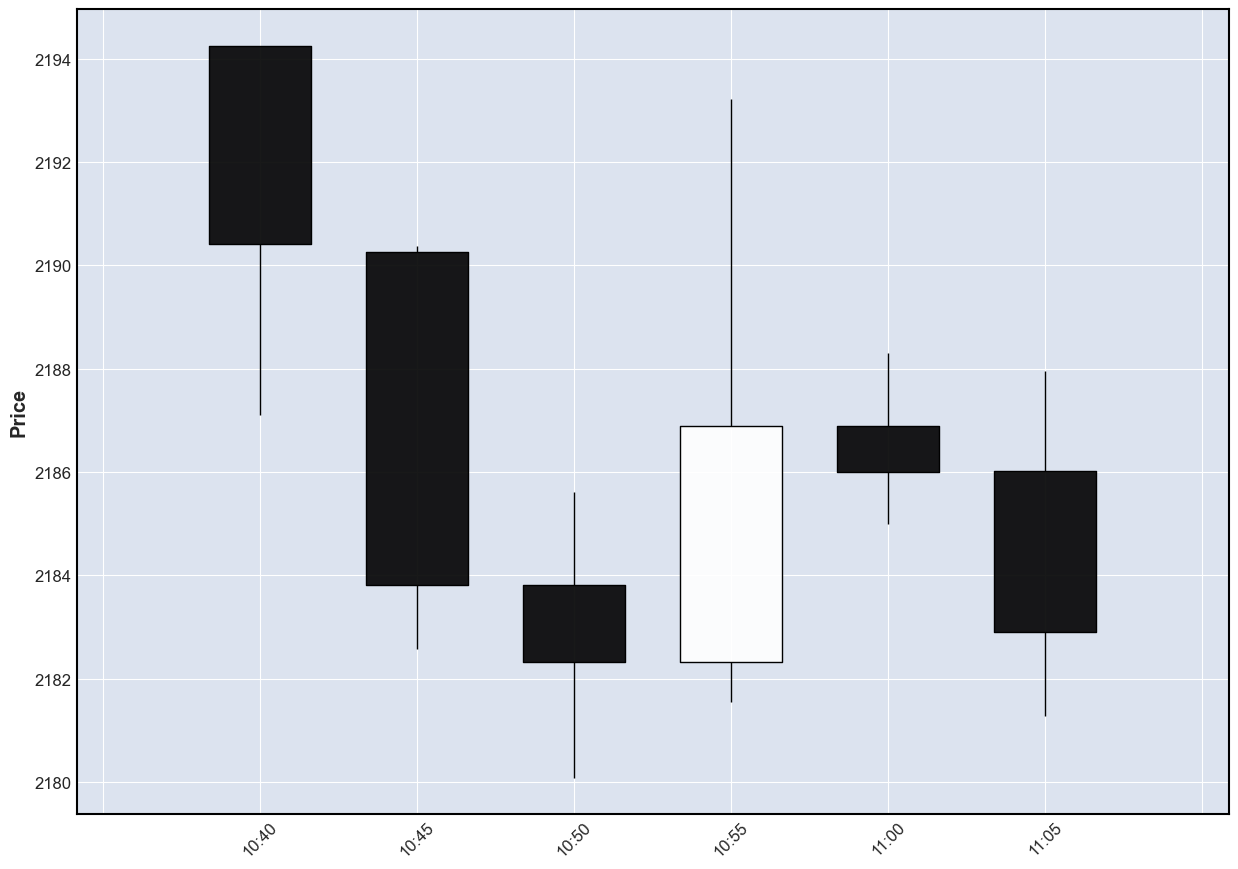

,cdl_up,cdl_down,is_prev_trend_down
time,,,
2024-01-25 10:40:00,False,True,False
2024-01-25 10:45:00,False,True,False
2024-01-25 10:50:00,False,True,False
2024-01-25 10:55:00,True,False,True
2024-01-25 11:00:00,False,True,False
2024-01-25 11:05:00,False,True,False


In [36]:
focus_data2 = test_data.between_time("10:40", "11:05").sort_index(ascending=True)


mpf.plot(focus_data2, type="candle", figscale=2.0)

focus_data2[["cdl_up", "cdl_down", "is_prev_trend_down", "ptn_biu]]